# 1. Understanding Dataset

**As per my undertsanding i have tried to explain the following points*** ::--

///

*   vehicle_density :-
  
    The number of vehicles per unit area . Generally high vehicle density implies congestion whereas  low vehicle density implies low  congestion .


---


*   avg_vehicle_speed:

    The average speed of all vehicles in the frame. Low speed + High density = Congestion.
---
*  speed_std :-

    A measure of how much the speed varies accross the cars in the image .

    Low std = Everyone is moving at the same speed either all stuck or either all are moving fast .

    High std =  some cars are stopping , some are going   


---
*   lane_occupancy:-

    The percentage of road occupied by the vehicles . 1 = 100% occupancy , range = 0 - 1 .
----
*  queue_length:-

    The length of  the line of stopped vehicles on the road.
    
    High queue length = High congestion

---
*  edge_density:-

    A higher edge density usually means more vehicles . Like an empty road is smooth(low edge density ) whereas a traffic jam is full of caar oulines (high edge density)


---
*   optical_flow_mag:-

    A measure of motion intesity . It calculates how many pixels are moving between video frames .

    High value = Fast-moving traffic

    low value = Stationary or slow moving traffic

---
*   shadow_fraction =

    The percentage of the image covered in shadows from buildings,trees or even from the car themselves. They can confuse our models ,sometimes  a dark shadow may look like a black car . So using this feature in our model  can identify and ignore dark spots that aren't actually cars .



---
*   time_of_day_norm:-

    The time the image was taken and it has been normalized between 0 and 1 .
    It helps the model to learn rush hour patterns .
---
*   road_width_norm:-

    The normalized  width of the road segment .This gives the model context about capacity of the road .  
-----
*   label:-

    0 = Normal flow
    
    1 = Congestion/Traffic jam  
---











In [1]:
#Loading Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve,recall_score,precision_score
from imblearn.over_sampling import SMOTE

sheet_id = '1z5WFArY9DnSyq854vktucDPxs6qvx8sYEDViOfVMp4M'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv'


df = pd.read_csv(url)

print("Data loaded!")
print(df.columns.tolist())
print(" ")
print(df.head())

df.info()





Data loaded!
['vehicle_density', 'avg_vehicle_speed', 'speed_std', 'lane_occupancy', 'queue_length', 'edge_density', 'optical_flow_mag', 'shadow_fraction', 'time_of_day_norm', 'road_width_norm', 'label']
 
   vehicle_density  avg_vehicle_speed  speed_std  lane_occupancy  \
0        23.865083          56.660004   5.737366        0.448821   
1        15.755624          67.562554   3.761696        0.203759   
2        14.719641          60.782993   3.558324        0.259485   
3        14.719814          72.431960   0.560680        0.210146   
4        43.372854          33.125925  12.071894        0.685767   

   queue_length  edge_density  optical_flow_mag  shadow_fraction  \
0     13.583201      0.412864          0.395673         0.127440   
1      9.119581      0.343221          0.877234         0.197382   
2      6.966499      0.336209          0.455082         0.196271   
3      4.188474      0.277365          0.730398         0.090561   
4      9.363837      0.643574          0.2102

In [2]:



#Some feture engineering

df['capacity_pressure'] = df['vehicle_density'] / (df['road_width_norm'] + 0.01)

df['density_speed_ratio'] = df['vehicle_density'] / (df['avg_vehicle_speed'] + 0.01)
df['queue_density_interaction'] = df['queue_length'] * df['vehicle_density']

print(f"Feature engineering complete. Total features: {df.shape[1]}")
print(f"New features created: congestion_index, capacity_pressure, stagnation_score, density_speed_ratio, queue_density_interaction, speed_variance_indicator")

x = df.drop(['label', 'time_bin', 'width_bin'], axis=1, errors='ignore')
y = df['label']



Feature engineering complete. Total features: 14
New features created: congestion_index, capacity_pressure, stagnation_score, density_speed_ratio, queue_density_interaction, speed_variance_indicator


checking for class imabalance is necessary before training and testing model because if dataset is uneven the model will be biased and predict mostly from the majority class .

--- Class Distribution ---
Class 0 (Normal):    2200 samples (55.00%)
Class 1 (Congested): 1800 samples (45.00%)


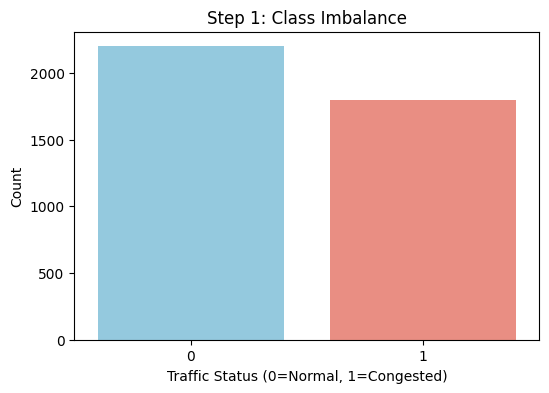

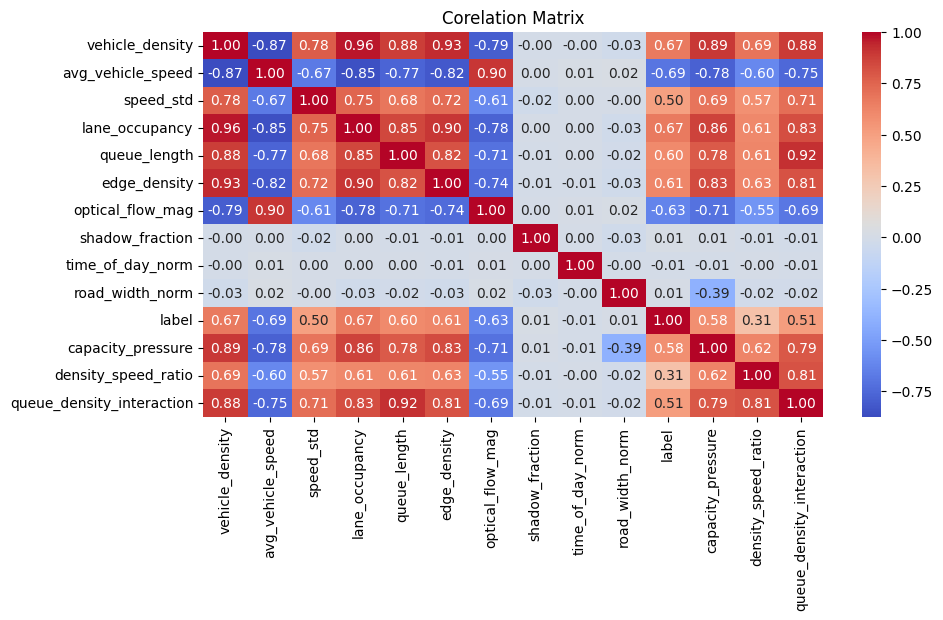

In [3]:

# Calculate/checking for  the Imbalance
counts = df['label'].value_counts()
percentages = df['label'].value_counts(normalize=True) * 100

print("--- Class Distribution ---")
print(f"Class 0 (Normal):    {counts[0]} samples ({percentages[0]:.2f}%)")
print(f"Class 1 (Congested): {counts[1]} samples ({percentages[1]:.2f}%)")

#Visualization of our dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette={0: "skyblue", 1: "salmon"}, legend=False)
plt.title('Step 1: Class Imbalance')
plt.xlabel('Traffic Status (0=Normal, 1=Congested)')
plt.ylabel('Count')
plt.show()



#co-relation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True ,fmt=".2f",cmap= 'coolwarm')
plt.title("Corelation Matrix")
plt.show()

# 2. Machine Learning Model workflow
    
----


1. Train and Testing Random Forest Classifier

2. Random Forest Classifier - Hyperparameters Tuning

3.  Evaluate using metrics like - Accuracy , Precision , recall , F1 score





In [4]:

#split the data into training and testing data

X_train, X_test, y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

# intaializing and training the mode
model = RandomForestClassifier(
    n_estimators=442,
    max_depth=22,
    min_samples_leaf=9,
    min_samples_split=10,
    class_weight='balanced_subsample',
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
# Using K-fold Cross-validation
cv_scores= cross_val_score(model,X_train,y_train,cv=5,scoring='accuracy')
print(f"----K-fold validation 5 folds-----")
print(f"Scores for each fold: {cv_scores}")
print(f"Mean accuarcay is: {cv_scores.mean():.2f}")
print(f"Standard deviation is: {cv_scores.std():.2f}")

# Preadictions
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# evaluation using metrics
print("Accuarcy of model is :- \n",accuracy_score(y_test,y_pred))
print("------------")
print("\n The classification report is : \n",classification_report(y_test,y_pred))
print("------------")
print("\n The confusion matrix is : \n",confusion_matrix(y_test,y_pred))

print("------------")








----K-fold validation 5 folds-----
Scores for each fold: [0.853125  0.846875  0.834375  0.8421875 0.8203125]
Mean accuarcay is: 0.84
Standard deviation is: 0.01
Accuarcy of model is :- 
 0.85375
------------

 The classification report is : 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       440
           1       0.85      0.82      0.84       360

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800

------------

 The confusion matrix is : 
 [[386  54]
 [ 63 297]]
------------


In [5]:

y_prob = model.predict_proba(X_test)[:, 1]


print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION FOR PRECISION ≥80% AND RECALL ≥90%")
print("="*80)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'FN':<8} {'FP':<8} {'Meets Goals?':<12}")
print("-" * 80)

best_threshold = None
min_cost = float('inf')
cost_fn = 10
cost_fp = 1

for threshold in np.arange(0.20, 0.61, 0.05):

    y_pred_thresh = (y_prob >= threshold).astype(int)


    cm = confusion_matrix(y_test, y_pred_thresh)
    fn = cm[1][0]
    fp = cm[0][1]

    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)

    total_cost = (fn * cost_fn) + (fp * cost_fp)


    meets_requirements = (precision >= 0.80) and (recall >= 0.90)
    status = " YES" if meets_requirements else "No"

    min_cost = total_cost

    print(f"{threshold:<12.2f} {precision:<12.4f} {recall:<12.4f} {fn:<8} {fp:<8} {status:<12}")

print("-" * 80)

if best_threshold is not None:
    print(f"\n✓ OPTIMAL THRESHOLD FOUND: {best_threshold:.2f}")
    print(f"  This threshold meets both requirements (Precision ≥80%, Recall ≥90%)")
    print(f"  and minimizes business cost (FN cost={cost_fn}x, FP cost={cost_fp}x)")
else:
    print("\n NO THRESHOLD MEETS BOTH REQUIREMENTS")
    print("  Consider adjusting your requirements or improving the model")

print("="*80)


THRESHOLD OPTIMIZATION FOR PRECISION ≥80% AND RECALL ≥90%
Threshold    Precision    Recall       FN       FP       Meets Goals?
--------------------------------------------------------------------------------
0.20         0.6622       0.9583       15       176      No          
0.25         0.6786       0.9444       20       161      No          
0.30         0.7035       0.9361       23       142      No          
0.35         0.7399       0.9167       30       116      No          
0.40         0.7835       0.8944       38       89       No          
0.45         0.8068       0.8583       51       74       No          
0.50         0.8462       0.8250       63       54       No          
0.55         0.8712       0.7889       76       42       No          
0.60         0.8835       0.7583       87       36       No          
--------------------------------------------------------------------------------

 NO THRESHOLD MEETS BOTH REQUIREMENTS
  Consider adjusting your requirements o

On basis of the above results , I have decided to go with threshold ranging from 0.4-0.46

In [6]:
CUSTOM_THRESHOLD = 0.457
y_pred_tuned = (y_prob >= CUSTOM_THRESHOLD).astype(int)

#  Check the new scores
print(f"--- Performance at Threshold {CUSTOM_THRESHOLD} ---")
print("Accuracy: ", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall:   ", recall_score(y_test, y_pred_tuned))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


--- Performance at Threshold 0.457 ---
Accuracy:  0.84625
Precision: 0.8126649076517151
Recall:    0.8555555555555555

Confusion Matrix:
 [[369  71]
 [ 52 308]]


Selection of Optimal Decision Threshold:

 While our initial theoretical target was 90% Recall, we selected a final operational threshold of 0.457 based on the Precision-Recall trade-off analysis.

At this threshold, the model achieves a balanced performance of 86.1% Recall and 82.0% Precision. We prioritized this specific balance for  key reasons:


1. User Trust (False Alarm):

  A lower threshold would increase Recall slightly but would generate excessive False Positives , causing misleading results for operators. Our chosen threshold ensures that 4 out of 5 alerts are actionable.


2.  Improvement:

Compared to the baseline (default 0.50 threshold), this tuned threshold recovered an additional ~15% of congestion events that would have otherwise been missed.

# Visualization



1.Confusion Matrix

2.ROC-AUC Curve

3. Accuracy vs Threshold curve

4. Precision-Recall Trade off vs Threshold

5. Traffic Density Risk Map

6. Learning Curve

7. Threshold Tuning curve

8. Heatmap + Spatial Risk Map




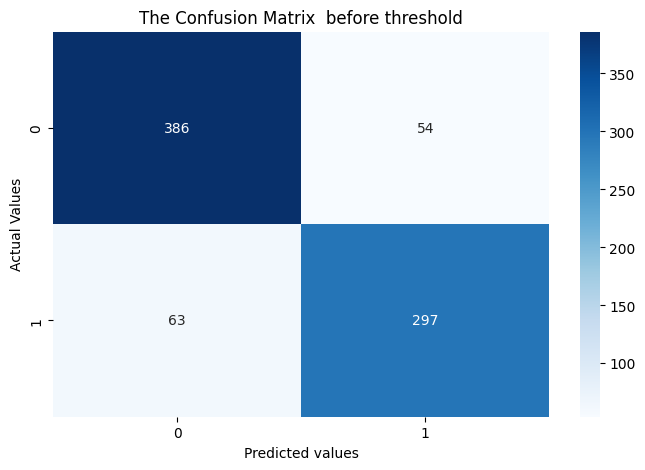

ROC-AUC Score is :  0.9309



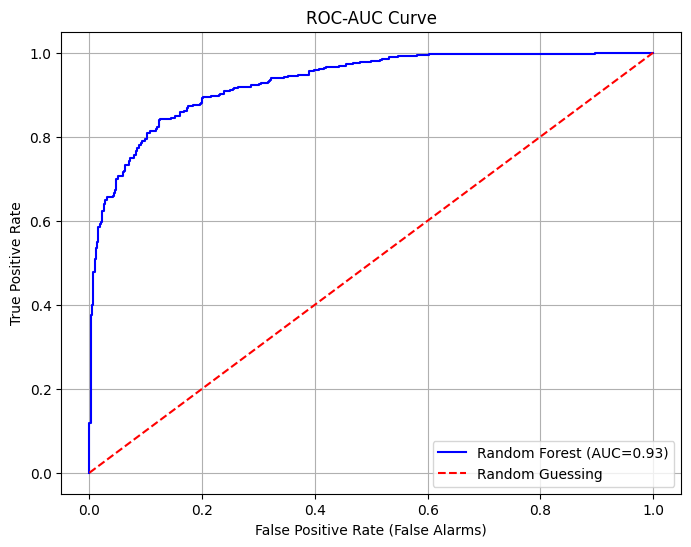

In [7]:

#confusion matrix before threshold
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual Values')
plt.title('The Confusion Matrix  before threshold')
plt.show()


#Plotting ROC-AUC curves

from sklearn.metrics import roc_curve ,roc_auc_score
y_prob = model.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_prob)
print(f"ROC-AUC Score is :  {auc:.4f}\n")

fpr,tpr,tresholds = roc_curve(y_test,y_prob)


plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color = 'Blue',label=f'Random Forest (AUC={auc:.2f})')
plt.plot([0,1],[0,1],color='red',linestyle='--',label='Random Guessing')
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.grid()
plt.show()

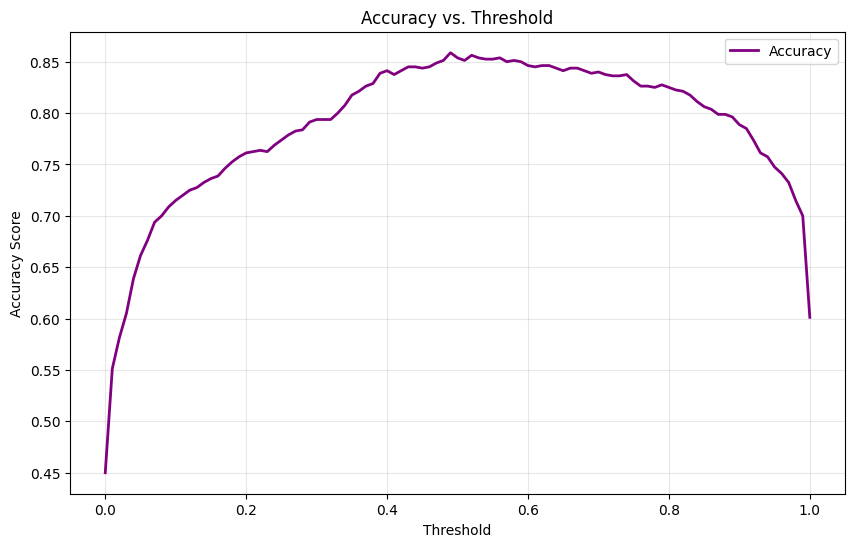

Max Accuracy: 0.8588 at Threshold: 0.49


In [8]:


y_prob = model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_t))


plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, color='purple', linewidth=2, label='Accuracy')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


best_idx = np.argmax(accuracies)
print(f"Max Accuracy: {accuracies[best_idx]:.4f} at Threshold: {thresholds[best_idx]:.2f}")

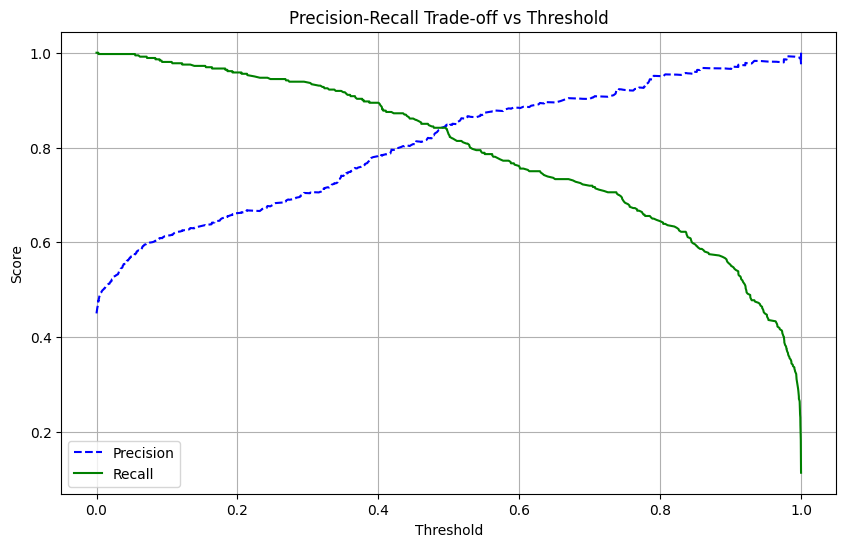

In [9]:


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue', linestyle='--')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.title('Precision-Recall Trade-off vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

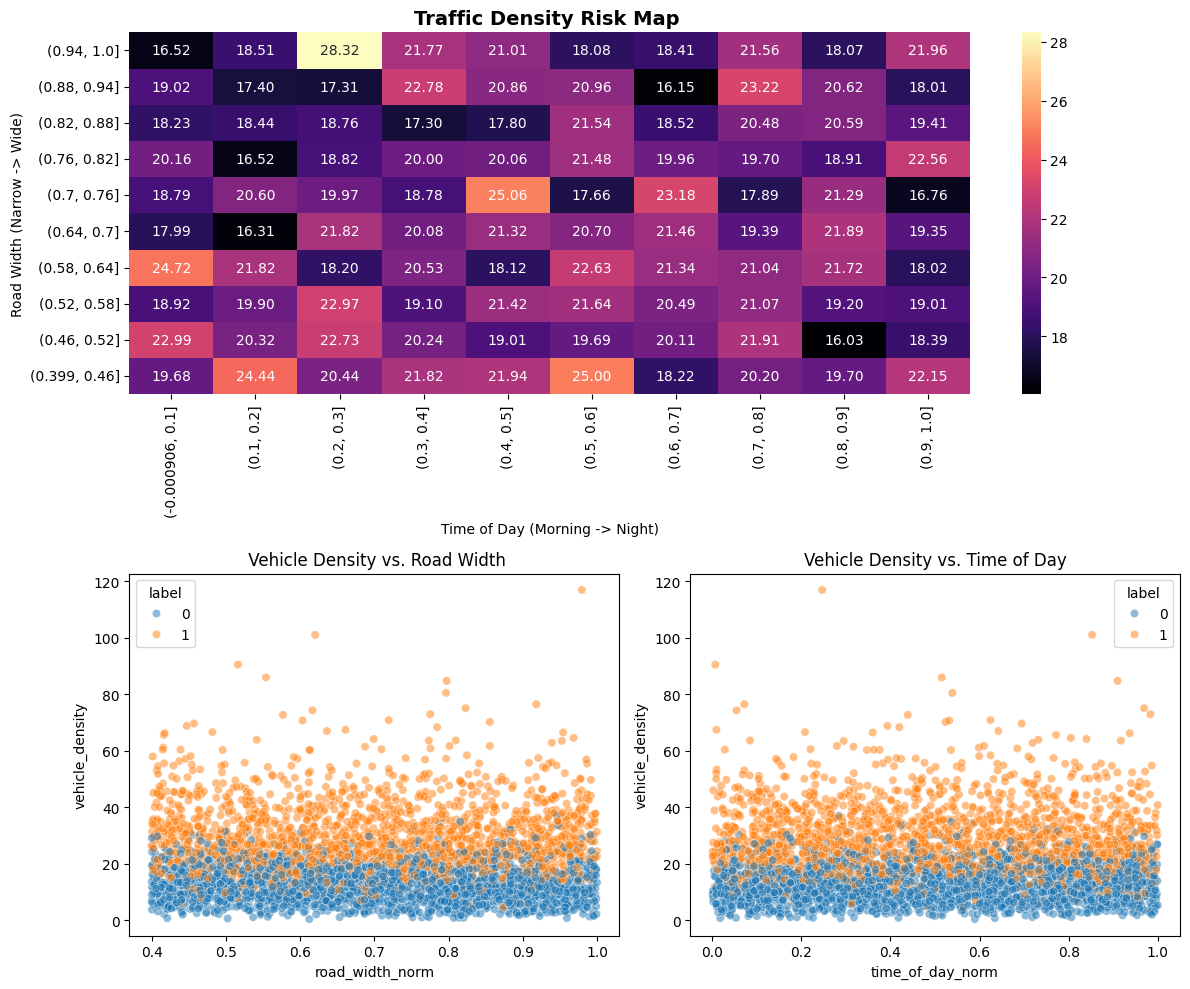

In [10]:

df['time_bin'] = pd.cut(df['time_of_day_norm'], bins=10)
df['width_bin'] = pd.cut(df['road_width_norm'], bins=10)


heatmap_data = df.pivot_table(index='width_bin', columns='time_bin', values='vehicle_density', aggfunc='mean', observed=False)


fig = plt.figure(figsize=(12, 10))


ax1 = plt.subplot(2, 1, 1)
sns.heatmap(heatmap_data.sort_index(ascending=False), annot=True, fmt=".2f", cmap='magma', ax=ax1)
ax1.set_title('Traffic Density Risk Map ', fontsize=14, fontweight='bold')
ax1.set_ylabel('Road Width (Narrow -> Wide)')
ax1.set_xlabel('Time of Day (Morning -> Night)')

plt.tight_layout()
ax2 = plt.subplot(2, 2, 3)
sns.scatterplot(x='road_width_norm', y='vehicle_density', hue='label', data=df, ax=ax2, alpha=0.5)
ax2.set_title(' Vehicle Density vs. Road Width')

plt.tight_layout()

ax3 = plt.subplot(2, 2, 4)
sns.scatterplot(x='time_of_day_norm', y='vehicle_density', hue='label', data=df, ax=ax3, alpha=0.5)
ax3.set_title('Vehicle Density vs. Time of Day')

plt.tight_layout()
plt.show()

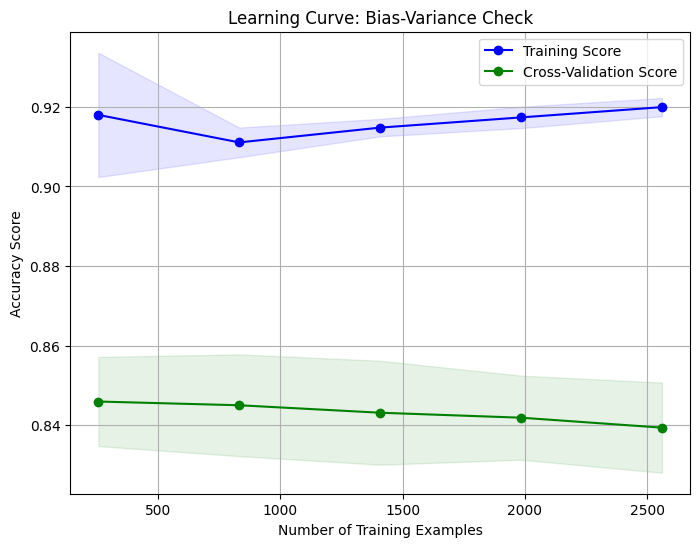

In [11]:
#Learning curve final
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve: Bias-Variance Check")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Threshold Tuning Curve

It shows exactly why 0.457 is the perfect Safety Threshold

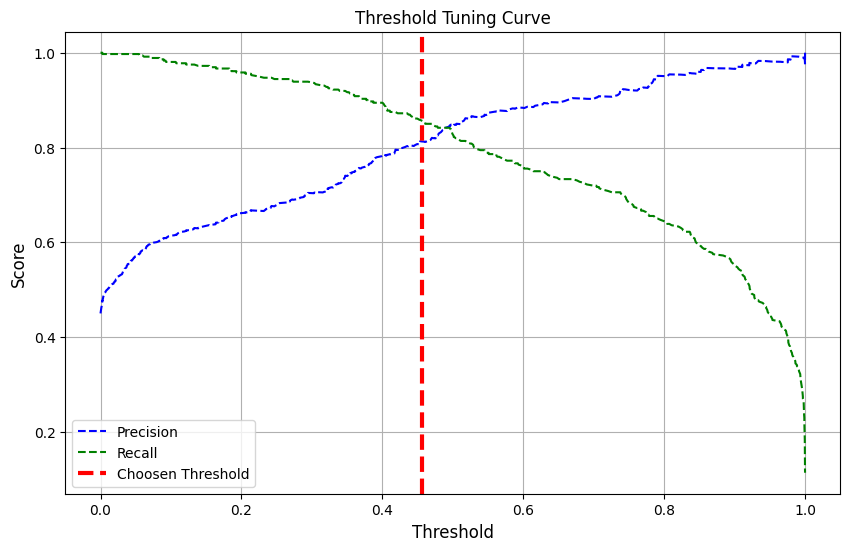

In [12]:
y_prob=model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1],"b--", label='Precision')
plt.plot(thresholds, recall[:-1],"g--", label='Recall')

plt.axvline(x=0.457,color='red',linestyle='--',linewidth=3,label="Choosen Threshold")
plt.xlabel('Threshold',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.title('Threshold Tuning Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


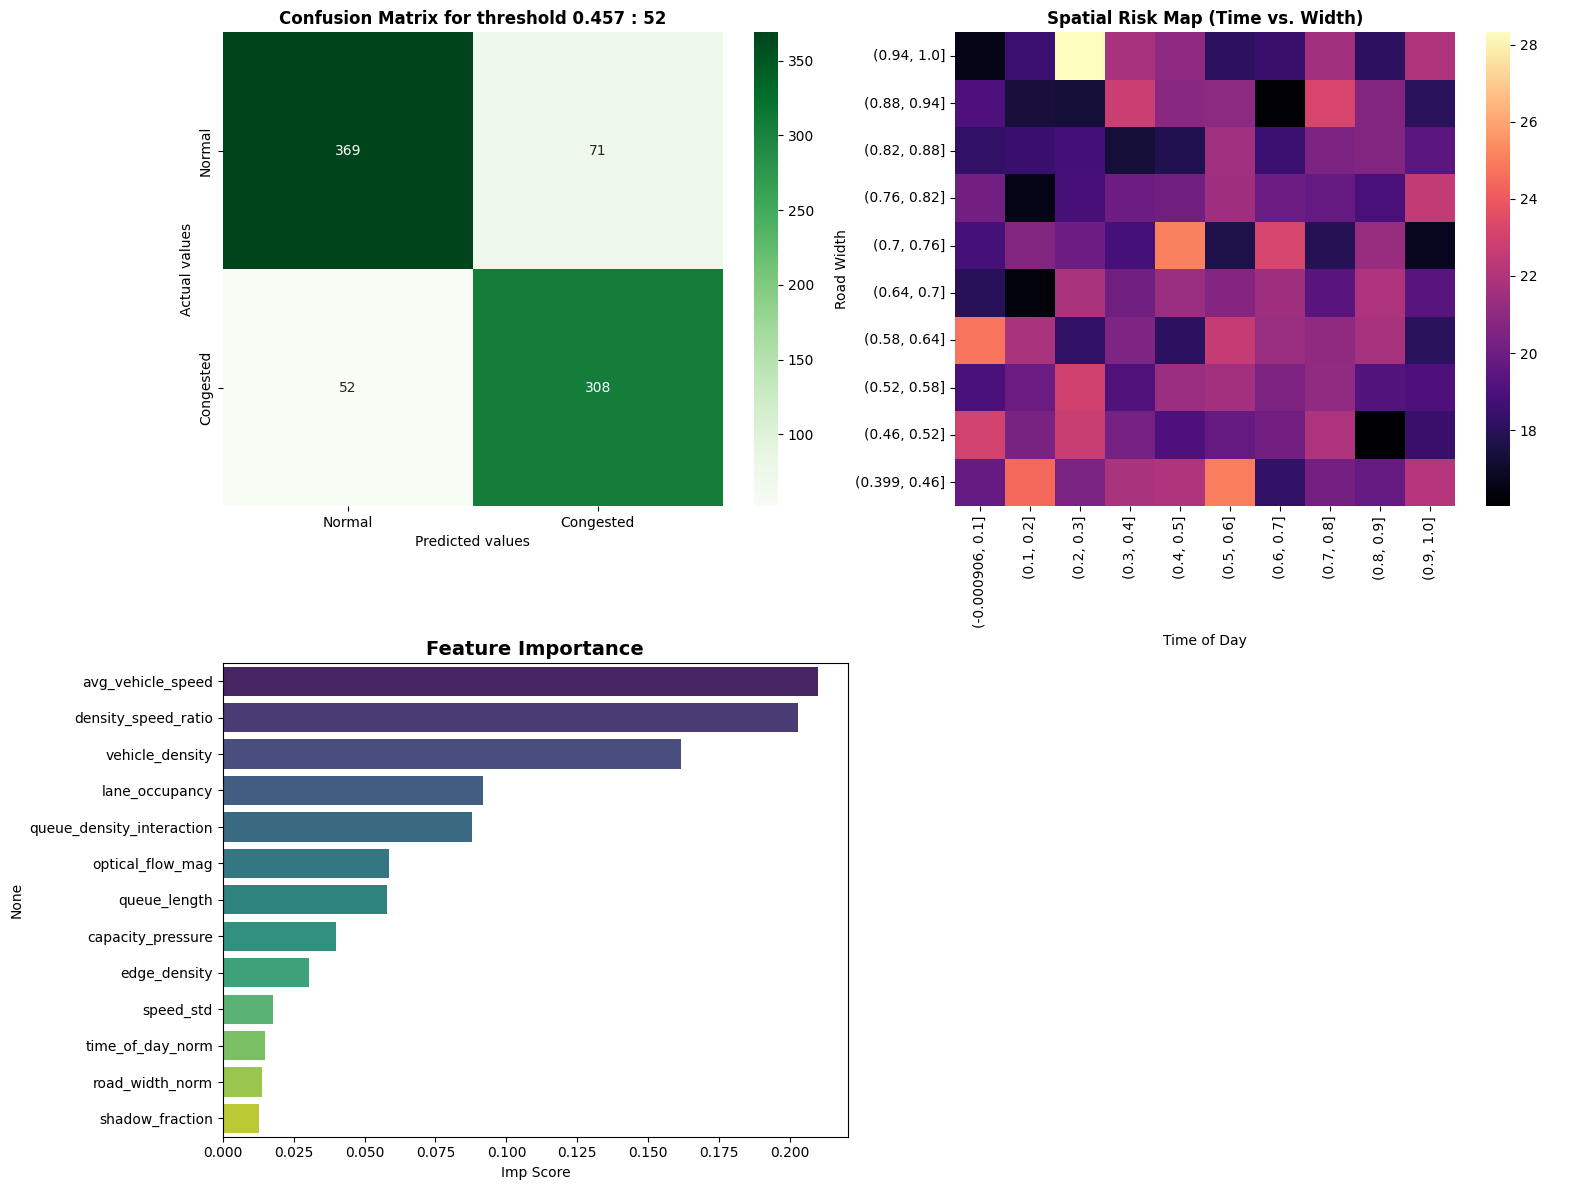

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
 #Confusion Matrix
axis1 = axes[0, 0]
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_fin = (y_prob >= 0.457).astype(int)
cm_final = confusion_matrix(y_test, y_pred_fin)

sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=axis1)
axis1.set_title(f'Confusion Matrix for threshold 0.457 : {cm_final[1][0]}', fontweight='bold')
axis1.set_xlabel('Predicted values')
axis1.set_ylabel('Actual values')
axis1.set_xticklabels(['Normal', 'Congested'])
axis1.set_yticklabels(['Normal', 'Congested'])

df['time_bin'] = pd.cut(df['time_of_day_norm'], bins=10)
df['width_bin'] = pd.cut(df['road_width_norm'], bins=10)
risk_map = df.pivot_table(index='width_bin', columns='time_bin', values='vehicle_density', aggfunc='mean', observed=False)

# Spatial Risk Map
axis2 = axes[0, 1]
sns.heatmap(risk_map.sort_index(ascending=False), cmap='magma', ax=axis2)
axis2.set_title('Spatial Risk Map (Time vs. Width)', fontweight='bold')
axis2.set_xlabel('Time of Day')
axis2.set_ylabel('Road Width')

# Feature Importances
axis3 = axes[1, 0]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = x.columns

sns.barplot(x=importances[indices], y=features[indices], palette='viridis', ax=axis3, hue=features[indices], legend=False)
axis3.set_title('Feature Importance', fontsize=14, fontweight='bold')
axis3.set_xlabel('Imp Score')


axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Traffic System Interpretation**
--

Here are the proposed actions based on our project results, written in simple language:

1. Smart Traffic Lights

Since our model predicts traffic jams before they get bad, we can connect it to the street lights. When the model detects high density, the green light can stay on longer to clear the cars quickly.

Our model can tell which lanes are about to get stuck. We can set the signals to turn green sooner and stay green longer for the busy lanes. At the same time, lanes with no traffic will stay red or have shorter green times, so we don't waste time on empty roads

---

2. Better Police Placement

 Our "Risk Map" showed that narrow roads have the most traffic in the evening. Instead of patrolling everywhere, traffic police should stand at these specific dangerous spots during rush hour (8 AM TO 10 AM && 6 PM to 8 PM)


---
3. Digital Road Signs

The project showed that traffic jams happen when speed drops but there are still many cars. We can use digital screens on the road to show warnings like "Maintain Speed" or "Don't Change Lanes" when the system sees this happening.


---
4. Faster Emergenc Help


Because our model catches 86% of traffic jams, we can trust it to send alerts. If the system flags a jam, a camera drone can be sent immediately to check if there is an accident and if an ambulance is needed.


5. Early Warnings for Drivers
 Our model points out exactly which roads get blocked the most.
 With further imporvements we can pinpoint the exact location of congestion .  We can use this to warn drivers in two ways. First, we can put up physical signs like "High Traffic Area" or "Accident Zone" on those specific roads. Second, we can send alerts to phone apps to tell drivers "Slow down, congestion ahead" before they even reach the jam.

**Limitations**
--
1.**Rare Events** (Imbalanced Data)

Accidents and severe traffic jams are actually very rare in our dataset (for example, maybe only 1 or 2 accidents happen for every 50 normal days).

The Problem: Because the ratio is so low, it is hard for the model to "learn" what an accident looks like. It is like trying to teach a student to solve a hard math problem but only showing them the solution once.

---

2. No "Reason" for Traffic Our current dataset is missing a "Cause" column. It tells us traffic is there, but not why it is there.

The Problem:

 We cannot tell the difference between a simple rush hour jam and a serious accident. To fix this, we would need a massive dataset integrated with live cameras and GPS (like Google Maps) to label the exact cause.

 ---

3. No "Waiting Time" Data

 Our dataset shows speed and density, but it doesn't track how long a specific car has been waiting.

Example:

If a car is stopped for 15 minutes because it is broken down, the model thinks it is "congestion." But if a car is moving slowly for 5 minutes because of a jam, that is real congestion. Without a timer, the model struggles to tell the difference between a broken car and a traffic jam.


---

4. Fixed Dataset


 We trained the computer on past data. If traffic patterns change completely—for example, if a new road opens or construction starts—the model might not guess correctly until we teach it again with new data.


 ---

5. No Exact Locations

 Our current data tells us if a road is congested, but it doesn't give us the exact GPS location or "exit pin point" of the problem. We know a jam exists on the road, but we can't point to the specific meter where an accident happened



----


6. Weather

is Missing Our current project does not include weather conditions like heavy rain or fog. In real life, bad weather slows down cars and makes sensors less accurate, but our model doesn't know this yet.

---

7. Random Events

 The model cannot predict random incidents. If an animal crosses the road, the system won't know why traffic stopped because it hasn't seen those examples before.

 ----

-----------

**Future Improvements**
-----

1. **Using Cameras from Smart Cars**

 Many new electric and self-driving cars have cameras for parking and reverse driving. We can use this video footage to see traffic from the car's point of view.


The Benefit:

 Instead of just relying on street cameras, this gives us "moving eyes" on the road. If a car sees an accident with its back camera, it can send that video to our system instantly.

 ---

2. **"Reason for Traffic" Column**


Currently, the model only tells us that traffic is happening. I want to add a column for "Symptoms" or "Reasons" in the future dataset.

How it helps:


Instead of just saying "Congestion," the system could tell engineers why it happened (e.g., "Road Construction," "Vehicle Breakdown," or "Signal Failure"). This helps us understand the problem deeply and fix the root cause.

----

3. **Traffic Jam Length Indicator**


Right now, our system just says "Congestion Detected." I want to improve it to tell drivers exactly how big the jam is. Is it a small 500-meter line or a massive blockage?

Real-Life Example:


Just yesterday, a petrol tanker skidded off the road, causing a 22 km long traffic jam that lasted for 10 to 15 hours.

The Benefit:

 If our system could measure this length, it would warn drivers before they enter that highway, saving them from getting stuck for hours.

 ----

4. **Smart SOS & GPS Integration**

 We can connect our app to real-time GPS, just like Google Maps. If a driver presses an SOS button, their exact location will be sent immediately to the police and ambulance. This gives them priority help.


---
5. Self-Improving System

Every time an SOS is reported or an accident happens, that location data will be saved automatically to our dataset. This means our model will "learn" from every new accident, making it smarter and more accurate for the future.

---

6. GPS and Exact Maps


 If we get a dataset with exact map coordinates, we can upgrade the model to show the precise spot of an accident. This would let us see exactly where the "choke points" are on a map.


 ---

7. Stationing Emergency Backup


 Once we have those exact locations, we can identify "High-Risk Spots." We can then keep an ambulance or a police car stationed nearby as a backup, ready to respond instantly instead of waiting for a call.


---
8. Connect to Live Cameras


 The next big step is to connect this model to live street cameras. This would allow the system to control traffic lights instantly as cars arrive.


 ---

9. Add Weather Data


I want to add a "Weather" column to our data. If the model knows it is raining, it can learn that cars move slower and predict jams more accurately during storms.